In [17]:
import logging
from itertools import chain
from pyomo.environ import ConcreteModel, Var, NonNegativeReals, Objective, minimize, Constraint, Suffix, SolverFactory, Param, RangeSet
from scipy.integrate import odeint
from scipy.interpolate import interp2d
from utils import solve
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def mpc_double_integrator(N=2, h=1):
    m = ConcreteModel()
    m.states = RangeSet(1, 2)
    m.k = RangeSet(0, N)
    
    m.h = Param(initialize=h, mutable=True)
    m.ic = Param(m.states, initialize={1:0.5, 2:0.5}, mutable=True)
    m.gamma = Param(default=0.5, mutable=True)
    
    m.x = Var(m.states, m.k)
    m.icfix = Constraint(m.states, rule = lambda m, i: m.x[i,0] == m.ic[i])
    m.x[1,N].fix(0)
    m.x[2,N].fix(0)
    
    m.u = Var(m.k, bounds=(-1, 1))
    m.upos = Var(m.k, bounds=(0, 1))
    m.uneg = Var(m.k, bounds=(0, 1))
    m.usum = Constraint(m.k, rule = lambda m, k: m.u[k] == m.upos[k] - m.uneg[k])   
  
    m.y = Var(m.k, bounds=(-1, 1))
    m.ypos = Var(m.k, bounds=(0, 1))
    m.yneg = Var(m.k, bounds=(0, 1))
    m.ysum = Constraint(m.k, rule = lambda m, k: m.y[k] == m.ypos[k] - m.yneg[k])

    m.x1_update = Constraint(m.k, rule = lambda m, k:
           m.x[1,k+1] == m.x[1,k] + m.h*m.x[2,k] + m.h**2*m.u[k]/2 if k < N else Constraint.Skip)
    m.x2_update = Constraint(m.k, rule = lambda m, k:
           m.x[2,k+1] == m.x[2,k] + m.h*m.u[k] if k < N else Constraint.Skip)
    m.y_output = Constraint(m.k, rule = lambda m, k: m.y[k] == m.x[1,k])
    
    m.uobj = m.gamma*sum(m.upos[k] + m.uneg[k] for k in m.k)
    m.yobj = (1-m.gamma)*sum(m.ypos[k] + m.yneg[k] for k in m.k)
    m.obj = Objective(expr = m.uobj + m.yobj, sense=minimize)
    
    return m



In [6]:
def plot_results(m):
    results = SolverFactory('glpk', executable='/usr/local/bin/glpsol').solve(m)
    if str(results.solver.termination_condition) != "optimal":
        print(results.solver.termination_condition)
        return
    
    # solution data at sample times
    h = m.h()
    K = np.array([k for k in m.k])  
    u = [m.u[k]() for k in K]
    y = [m.y[k]() for k in K]
    v = [m.x[2,k]() for k in K]
    
    # interpolate between sample times
    t = np.linspace(0, h) 
    tp = [_ for _ in chain.from_iterable(k*h + t for k in K[:-1])]
    up = [_ for _ in chain.from_iterable(u[k] + t*0 for k in K[:-1])]
    yp = [_ for _ in chain.from_iterable(y[k] + t*(v[k] + t*u[k]/2) for k in K[:-1])]
    vp = [_ for _ in chain.from_iterable(v[k] + t*u[k] for k in K[:-1])]

    fig = plt.figure(figsize=(10,5))
    
    ax1 = fig.add_subplot(3, 2, 1)
    ax1.plot(tp, yp, 'r--', h*K, y, 'bo')
    ax1.set_title('position')

    ax2 = fig.add_subplot(3, 2, 3)
    ax2.plot(tp, vp, 'r--', h*K, v, 'bo')
    ax2.set_title('velocity')

    ax3 = fig.add_subplot(3, 2, 5)
    ax3.plot(np.append(tp, K[-1]*h), np.append(up, u[-1]), 'r--', h*K, u, 'bo')
    ax3.set_title('control force  u[0] = {0:<6.3f}'.format(u[0]))

    ax4 = fig.add_subplot(1, 2, 2)
    ax4.plot(yp, vp, 'r--', y, v, 'bo')
    ax4.set_xlim([-1.1, 1.1])
    ax4.set_aspect('equal', 'box')
    ax4.set_title('phase plane')
    ax4.set_xlabel('position')
    ax4.set_ylabel('velocity')
    
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_ylim(-1.1, 1.1)
        ax.grid(True)
    fig.tight_layout()

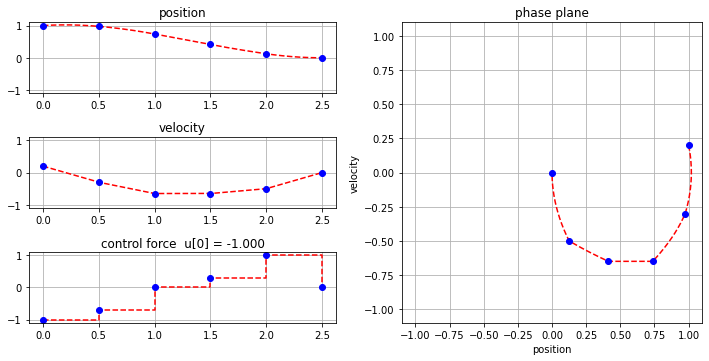

In [7]:
model = mpc_double_integrator(5, 0.5)
model.ic[1] = 1.0
model.ic[2] = 0.2

SolverFactory('glpk', executable='/usr/local/bin/glpsol').solve(model)
plot_results(model)

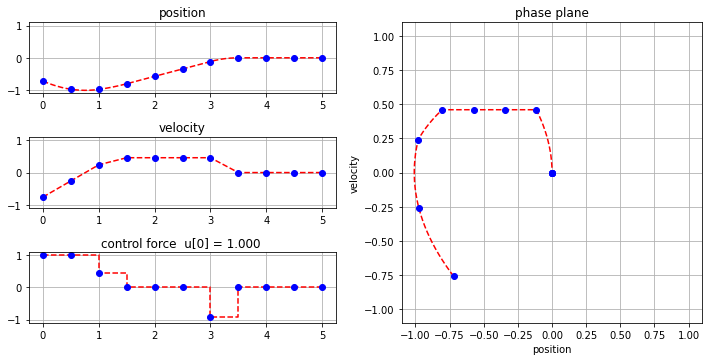

In [8]:
#@title Interactive { run: "auto" }

N = 10 #@param {type: "slider", min:1, max:20, step:1}
h = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}
gamma = 0.54 #@param {type:"slider", min:0, max:1, step:0.01}
x_initial = -0.72 #@param {type:"slider", min:-1, max:1, step:0.01}
v_initial = -0.76 #@param {type:"slider", min:-1, max:1, step:0.01}

model = mpc_double_integrator(N, h)
model.gamma = gamma
model.ic[1] = x_initial
model.ic[2] = v_initial

SolverFactory('glpk', executable='/usr/local/bin/glpsol').solve(model)
plot_results(model)



Text(0.5, 0, 'control force')

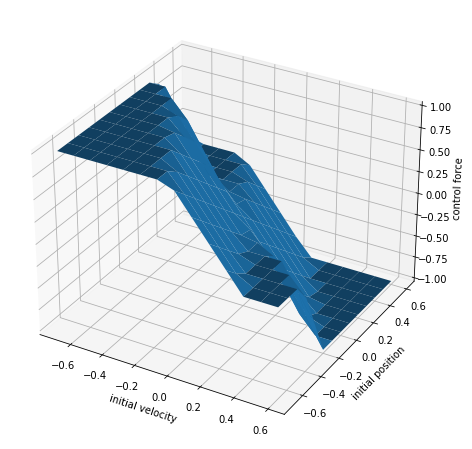

In [12]:
# turn off pyomo warnings
logging.getLogger('pyomo.core').setLevel(logging.ERROR)

model = mpc_double_integrator(10)
model.h = 0.5
model.gamma = 0.4

def fun(y, v):
    u = 0*y
    for i in range(0, len(y)):
        model.ic[1] = y[i]
        model.ic[2] = v[i]
        results = SolverFactory('glpk', executable='/usr/local/bin/glpsol').solve(model)
        if str(results.solver.termination_condition) == 'optimal':
            u[i] = model.u[0]()
        else:
            u[i] = None
    return u

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

y = v = np.arange(-0.7, 0.7, 0.1)
Y, V = np.meshgrid(y, v)
u = np.array(fun(np.ravel(Y), np.ravel(V)))
U = u.reshape(V.shape)

ax.plot_surface(V, Y, U)
ax.set_xlabel('initial velocity')
ax.set_ylabel('initial position')
ax.set_zlabel('control force')



In [18]:
mpc = interp2d(Y, V, U)

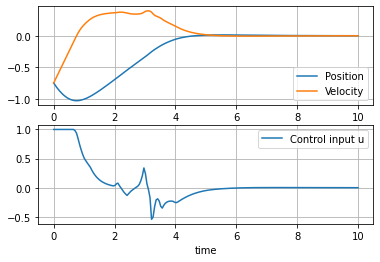

In [19]:
def mpc_sim(x, t):
    y, v = x
    return [v, mpc(y,v)]

t = np.linspace(0, 10, 200)
x = odeint(mpc_sim, [-0.75, -0.75], t)

plt.subplot(2,1,1)
plt.plot(t,x)
plt.xlabel('time')
plt.legend(['Position', 'Velocity'])
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(t, [mpc(x1, x2) for x1,x2 in x])
plt.xlabel('time')
plt.legend(['Control input u'])
plt.grid(True)

